## 1. Original data loading

In [1]:
import h5py
import numpy as np
import os
print(os.listdir("./Input/train"))

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

# To make this notebook's output stable across runs
random_state=14

with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
print(data_train.shape,label_train.shape)

with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
print(data_test.shape,label_test.shape)

['images_training.h5', 'labels_training.h5']
(30000, 784) (30000,)
(5000, 784) (2000,)


## 2. Data pre-processing

### 2.1 Normalization

In [2]:
# Before PCA, the dataset needs to be normalized
# But the values of data_train and data_test are already between 0 and 1
print(data_train[data_train<0])
print(data_train[data_train>1])

print(data_test[data_test<0])
print(data_test[data_test>1])

[]
[]
[]
[]


### 2.2Principal Component Analysis

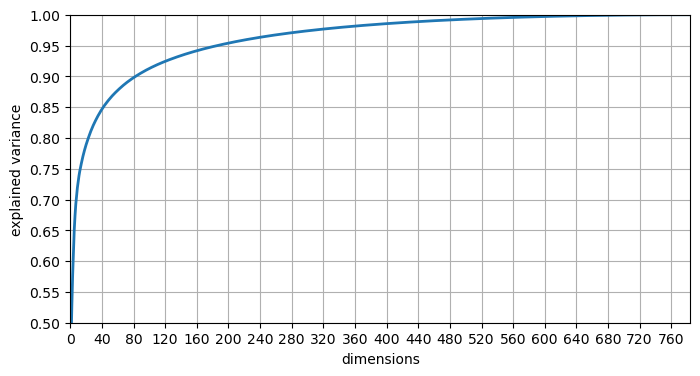

In [3]:
from sklearn.decomposition import PCA

# Perform PCA without reducing dimensionality
pca = PCA()
pca.fit(data_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance vs number of dimensions
plt.figure(figsize = (8,4))
plt.plot(cumsum, linewidth=2)
plt.axis([0, 784, 0.5, 1]) 
plt.xticks(np.arange(0, 784, 40)) 
plt.yticks(np.arange(0.5, 1.01, 0.05)) 
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

In [4]:
#select 95% explained variance of the data
pca = PCA(n_components=0.95).fit(data_train)#fit PCA model to the training data

#transform training data and test data onto to the selected principal components
X_train_pca = pca.transform(data_train)
X_test_pca = pca.transform(data_test)

print("Reduced shape of training data: {}".format(str(X_train_pca.shape)))
print("Reduced shape of test data: {}".format(str(X_test_pca.shape)))
#Data dimension reduced from 784 to 188

Reduced shape of training data: (30000, 188)
Reduced shape of test data: (5000, 188)


## 3. Declare main variables

In [5]:
# Variable declaration
X_train = X_train_pca
X_test_all = X_test_pca# Contain all of the test example(5000 rows) 
X_test = X_test_pca[:2000]# Define the first 2000 rows data in test data for self-testing

y_train = label_train
y_test = label_test# Only contain 2000 labels

## 4 Classification algorithms

### 4.1 Nearest Neighbor

In [5]:
%%time
# Fine-tune hyper-parameters for KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 7], # Create the parameter grid
                                          'p': [1, 2]}
print("Parameter grid: {}".format(param_grid))

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10,return_train_score=True)
# Use GridSearcCV on the training set
grid_search.fit(X_train, y_train)

print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best estimator: {}".format(grid_search.best_estimator_))
print("Test set (first 2000 rows) score: {:.4f}".format(grid_search.score(X_test, y_test)))
# Accuracy on test set of the model with selected best parameters

Parameter grid: {'n_neighbors': [3, 5, 7], 'p': [1, 2]}
Best cross-validation score: 0.8570
Best parameters: {'n_neighbors': 7, 'p': 1}
Best estimator: KNeighborsClassifier(n_neighbors=7, p=1)
Test set (first 2000 rows) score: 0.8405
Wall time: 1h 32min 7s


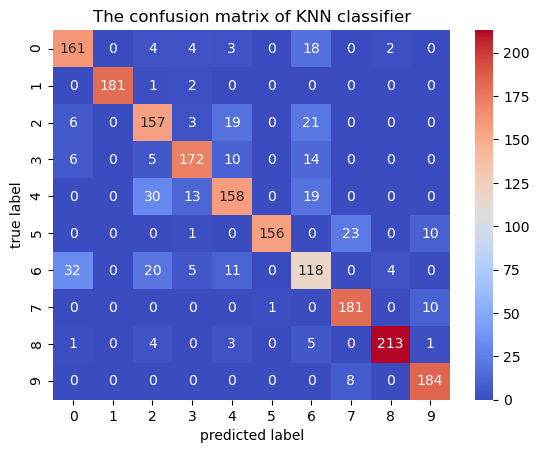

In [6]:
#Plot the confusion matrix of KNN classifier
y_test_pred = grid_search.best_estimator_.predict(X_test) #get the prediction of test set
actual = y_test
predicted = y_test_pred
sns.heatmap (confusion_matrix(actual, predicted), annot=True, fmt="d",cmap="coolwarm")
plt.title("The confusion matrix of KNN classifier")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show(sns)

In [63]:
# calculate other performance measures for the best KNN classifier
print(metrics.classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.78      0.84      0.81       192
           1       1.00      0.98      0.99       184
           2       0.71      0.76      0.74       206
           3       0.86      0.83      0.85       207
           4       0.77      0.72      0.75       220
           5       0.99      0.82      0.90       190
           6       0.61      0.62      0.61       190
           7       0.85      0.94      0.90       192
           8       0.97      0.94      0.96       227
           9       0.90      0.96      0.93       192

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



### 4.2 Logistic Regression

In [56]:
%%time
# Fine-tune hyper-parameters for Logistic Regression
from sklearn.linear_model import LogisticRegression

param_grid = {'C':[1,10],
             'multi_class': ['ovr', 'multinomial']}# Create the parameter grid
print("Parameter grid: {}".format(param_grid))

grid_search = GridSearchCV(LogisticRegression(random_state=14, max_iter =5000), 
                           param_grid, cv=10, return_train_score=True)
# Use GridSearcCV on the training set
grid_search.fit(X_train, y_train)

print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best estimator: {}".format(grid_search.best_estimator_))
print("Test set (first 2000 rows) score: {:.4f}".format(grid_search.score(X_test, y_test)))
# Accuracy on test set of the model with selected best parameters

Parameter grid: {'C': [1, 10], 'multi_class': ['ovr', 'multinomial']}
Best cross-validation score: 0.8540
Best parameters: {'C': 1, 'multi_class': 'multinomial'}
Best estimator: LogisticRegression(C=1, max_iter=5000, multi_class='multinomial',
                   random_state=14)
Test set (first 2000 rows) score: 0.8410
Wall time: 27min


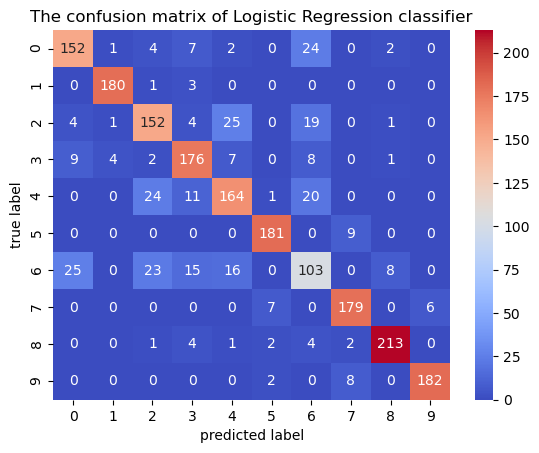

In [58]:
#Plot the confusion matrix of Logistic Regression classifier
y_test_pred = grid_search.best_estimator_.predict(X_test) #get the prediction of test set
actual = y_test
predicted = y_test_pred
sns.heatmap (confusion_matrix(actual, predicted), annot=True, fmt="d",cmap="coolwarm")
plt.title("The confusion matrix of Logistic Regression classifier")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show(sns)

In [61]:
# calculate other performance measures for the best Logistic Regression Classifier
print(metrics.classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       192
           1       0.97      0.98      0.97       184
           2       0.73      0.74      0.74       206
           3       0.80      0.85      0.82       207
           4       0.76      0.75      0.75       220
           5       0.94      0.95      0.95       190
           6       0.58      0.54      0.56       190
           7       0.90      0.93      0.92       192
           8       0.95      0.94      0.94       227
           9       0.97      0.95      0.96       192

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



### 4.3 SVM

In [11]:
%%time
# Fine-tune hyper-parameters for SVC
from sklearn.svm import SVC

param_grid = {'C':[10, 100],
               'kernel': ['poly', 'rbf']}# Create the parameter grid
print("Parameter grid: {}".format(param_grid))

grid_search = GridSearchCV(SVC(random_state=14), param_grid, cv=10, return_train_score=True) 
# Use GridSearcCV on the training set
grid_search.fit(X_train, y_train)

print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))
print("Best estimator: {}".format(grid_search.best_estimator_))
print("Test set (first 2000 rows) score: {:.4f}".format(grid_search.score(X_test, y_test)))
# Accuracy on test set of the model with selected best parameters

Parameter grid: {'C': [10, 100], 'kernel': ['poly', 'rbf']}
Best cross-validation score: 0.9004
Best parameters: {'C': 10, 'kernel': 'rbf'}
Best estimator: SVC(C=10, random_state=14)
Test set (first 2000 rows) score: 0.8890
Wall time: 1h 2min 27s


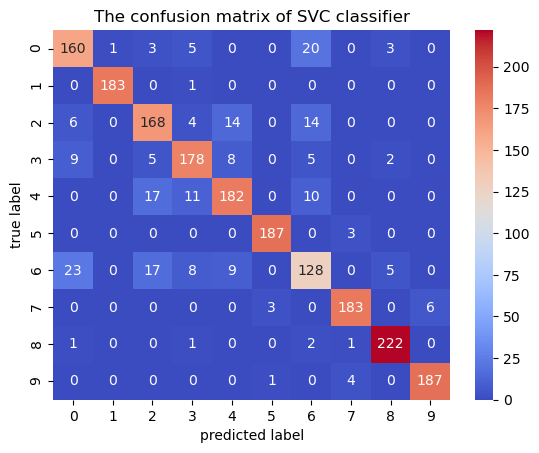

In [12]:
#Plot the confusion matrix of SVC classifier
y_test_pred = grid_search.best_estimator_.predict(X_test) #get the prediction of test set
actual = y_test
predicted = y_test_pred
sns.heatmap (confusion_matrix(actual, predicted), annot=True, fmt="d",cmap="coolwarm")
plt.title("The confusion matrix of SVC classifier")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show(sns)

In [65]:
# calculate other performance measures for the best SVC classifier
print(metrics.classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       192
           1       0.99      0.99      0.99       184
           2       0.80      0.82      0.81       206
           3       0.86      0.86      0.86       207
           4       0.85      0.83      0.84       220
           5       0.98      0.98      0.98       190
           6       0.72      0.67      0.69       190
           7       0.96      0.95      0.96       192
           8       0.96      0.98      0.97       227
           9       0.97      0.97      0.97       192

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



## 5. Output the prediction

### 5.1 Best classifier

In [6]:
%%time
from sklearn.svm import SVC

best_cls= SVC(C=10, random_state=14)
best_cls.fit(X_train, y_train)
output = best_cls.predict(X_test_all) #To get all 5000 prediction

y_test_pre = output[:2000] 
accuracy =  (y_test_pre == y_test).sum()/len(y_test_pre)
print("Test set accuracy on first 2000 rows: {:.2f}".format(accuracy))

Test set accuracy on first 2000 rows: 0.89
Wall time: 45.4 s


### 5.2 Export  file

In [7]:
import numpy as np
# assume output is the predicted labels from classifiers
# (5000,)
with h5py.File('Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=output)

## 6. Operating environment

* CPU: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz   1.80 GHz
* RAM: 8.00 GB (7.89 GB Available)
* GPU: NVIDIA GeForce MX250
* Software: Jupyter Notebook 6.3.0; Python 3.8.8
